# Transfer Learning with the MobileNet V2 architecture

In this notebook,  based on the recommendation of Daniyal Abbasi, I have used the same final layer architecture as the MobileNet (V1) to see if this model performs better or worse given the same data.

In [1]:
import os
import keras
import random
from keras import backend as K
import tensorflow as tf
from keras.layers.core import Dense, Activation
from keras import models
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
nsfw_images = [fn for fn in os.listdir(r'D:\Data\Train\NSFW') if fn.endswith('.jpg')]
sfw_images = [fn for fn in os.listdir(r'D:\Data\Train\SFW') if fn.endswith('.jpg')]
train_dir = r'D:\Data\Train'
validation_dir = r'D:\Data\Validation'

In [3]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [4]:
base_model=MobileNetV2(weights='imagenet',include_top=False, input_shape = (224, 224, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

In [5]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [7]:
#for i,layer in enumerate(model.layers):
#    print(i,layer.name)

In [6]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [7]:
model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

validation_generator =test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 30,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224, 224))

Found 6363 images belonging to 2 classes.
Found 2124 images belonging to 2 classes.


# Training and inferences

From what I could infer, the performances of the MobileNet V1 and V2 are comparable in terms of Validation accuracies (96.62% in V1 vs 96.38% in V2), however V2 sustains more validation losses (10.04% loss in V1 vs 12.51% loss in V2). So, I would rank the tested models as: MobileNet > MobileNet_V2 >> Inception_V3. 

In [18]:
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
batch_size = 30
#step_size_train=train_generator.n//train_generator.batch_size
#step_size_valid=validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
          validation_data=validation_generator,
          steps_per_epoch=int(6363/batch_size),
          validation_steps=int(2124/batch_size),
          epochs=10,
         callbacks=[callback_early_stopping, callback_reduce_lr])

Epoch 1/10
156/212 [=====================>........] - ETA: 1:23 - loss: 0.2777 - accuracy: 0.9079

C:\Users\Harshinee Sriram\anaconda3\lib\site-packages\PIL\Image.py:2832: DecompressionBombWarning: Image size (147659204 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


212/212 [==============================] - 404s 2s/step - loss: 0.2501 - accuracy: 0.9149 - val_loss: 0.2314 - val_accuracy: 0.9090
Epoch 2/10
212/212 [==============================] - 399s 2s/step - loss: 0.1492 - accuracy: 0.9436 - val_loss: 0.2326 - val_accuracy: 0.9148
Epoch 3/10
212/212 [==============================] - 393s 2s/step - loss: 0.1006 - accuracy: 0.9621 - val_loss: 0.1980 - val_accuracy: 0.9348
Epoch 4/10
212/212 [==============================] - 382s 2s/step - loss: 0.0766 - accuracy: 0.9744 - val_loss: 0.1797 - val_accuracy: 0.9433
Epoch 5/10
212/212 [==============================] - 381s 2s/step - loss: 0.0584 - accuracy: 0.9804 - val_loss: 0.1464 - val_accuracy: 0.9557
Epoch 6/10
212/212 [==============================] - 387s 2s/step - loss: 0.0491 - accuracy: 0.9834 - val_loss: 0.1475 - val_accuracy: 0.9571
Epoch 7/10
212/212 [==============================] - 392s 2s/step - loss: 0.0367 - accuracy: 0.9864 - val_loss: 0.1251 - val_accuracy: 0.9638
Epoch 8/10

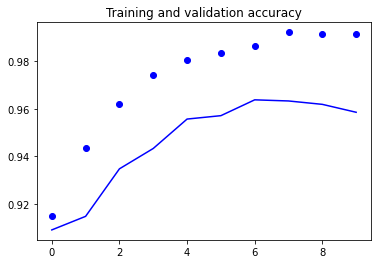

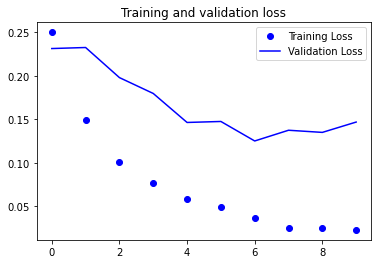

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
model.save('model_MobileNet_V2.h5')
#os.listdir()
#model = model.load_weights('modelMOBILE.07-0.102090.h5')

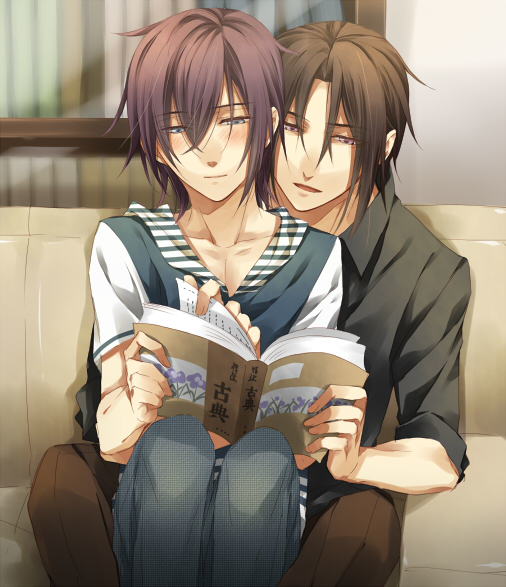

This is a SFW image


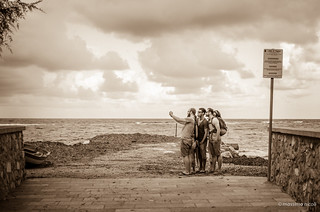

This is a SFW image


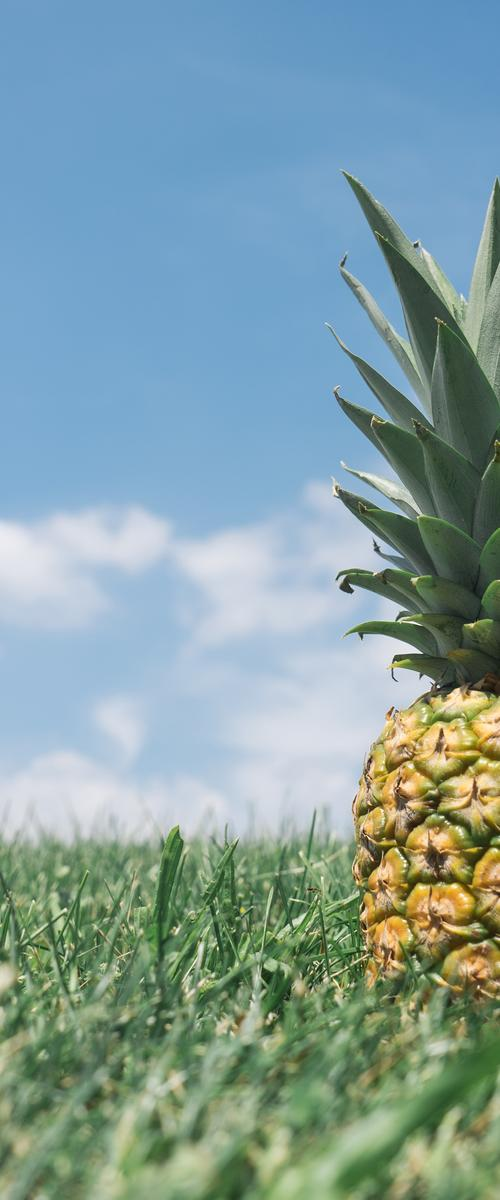

This is a SFW image


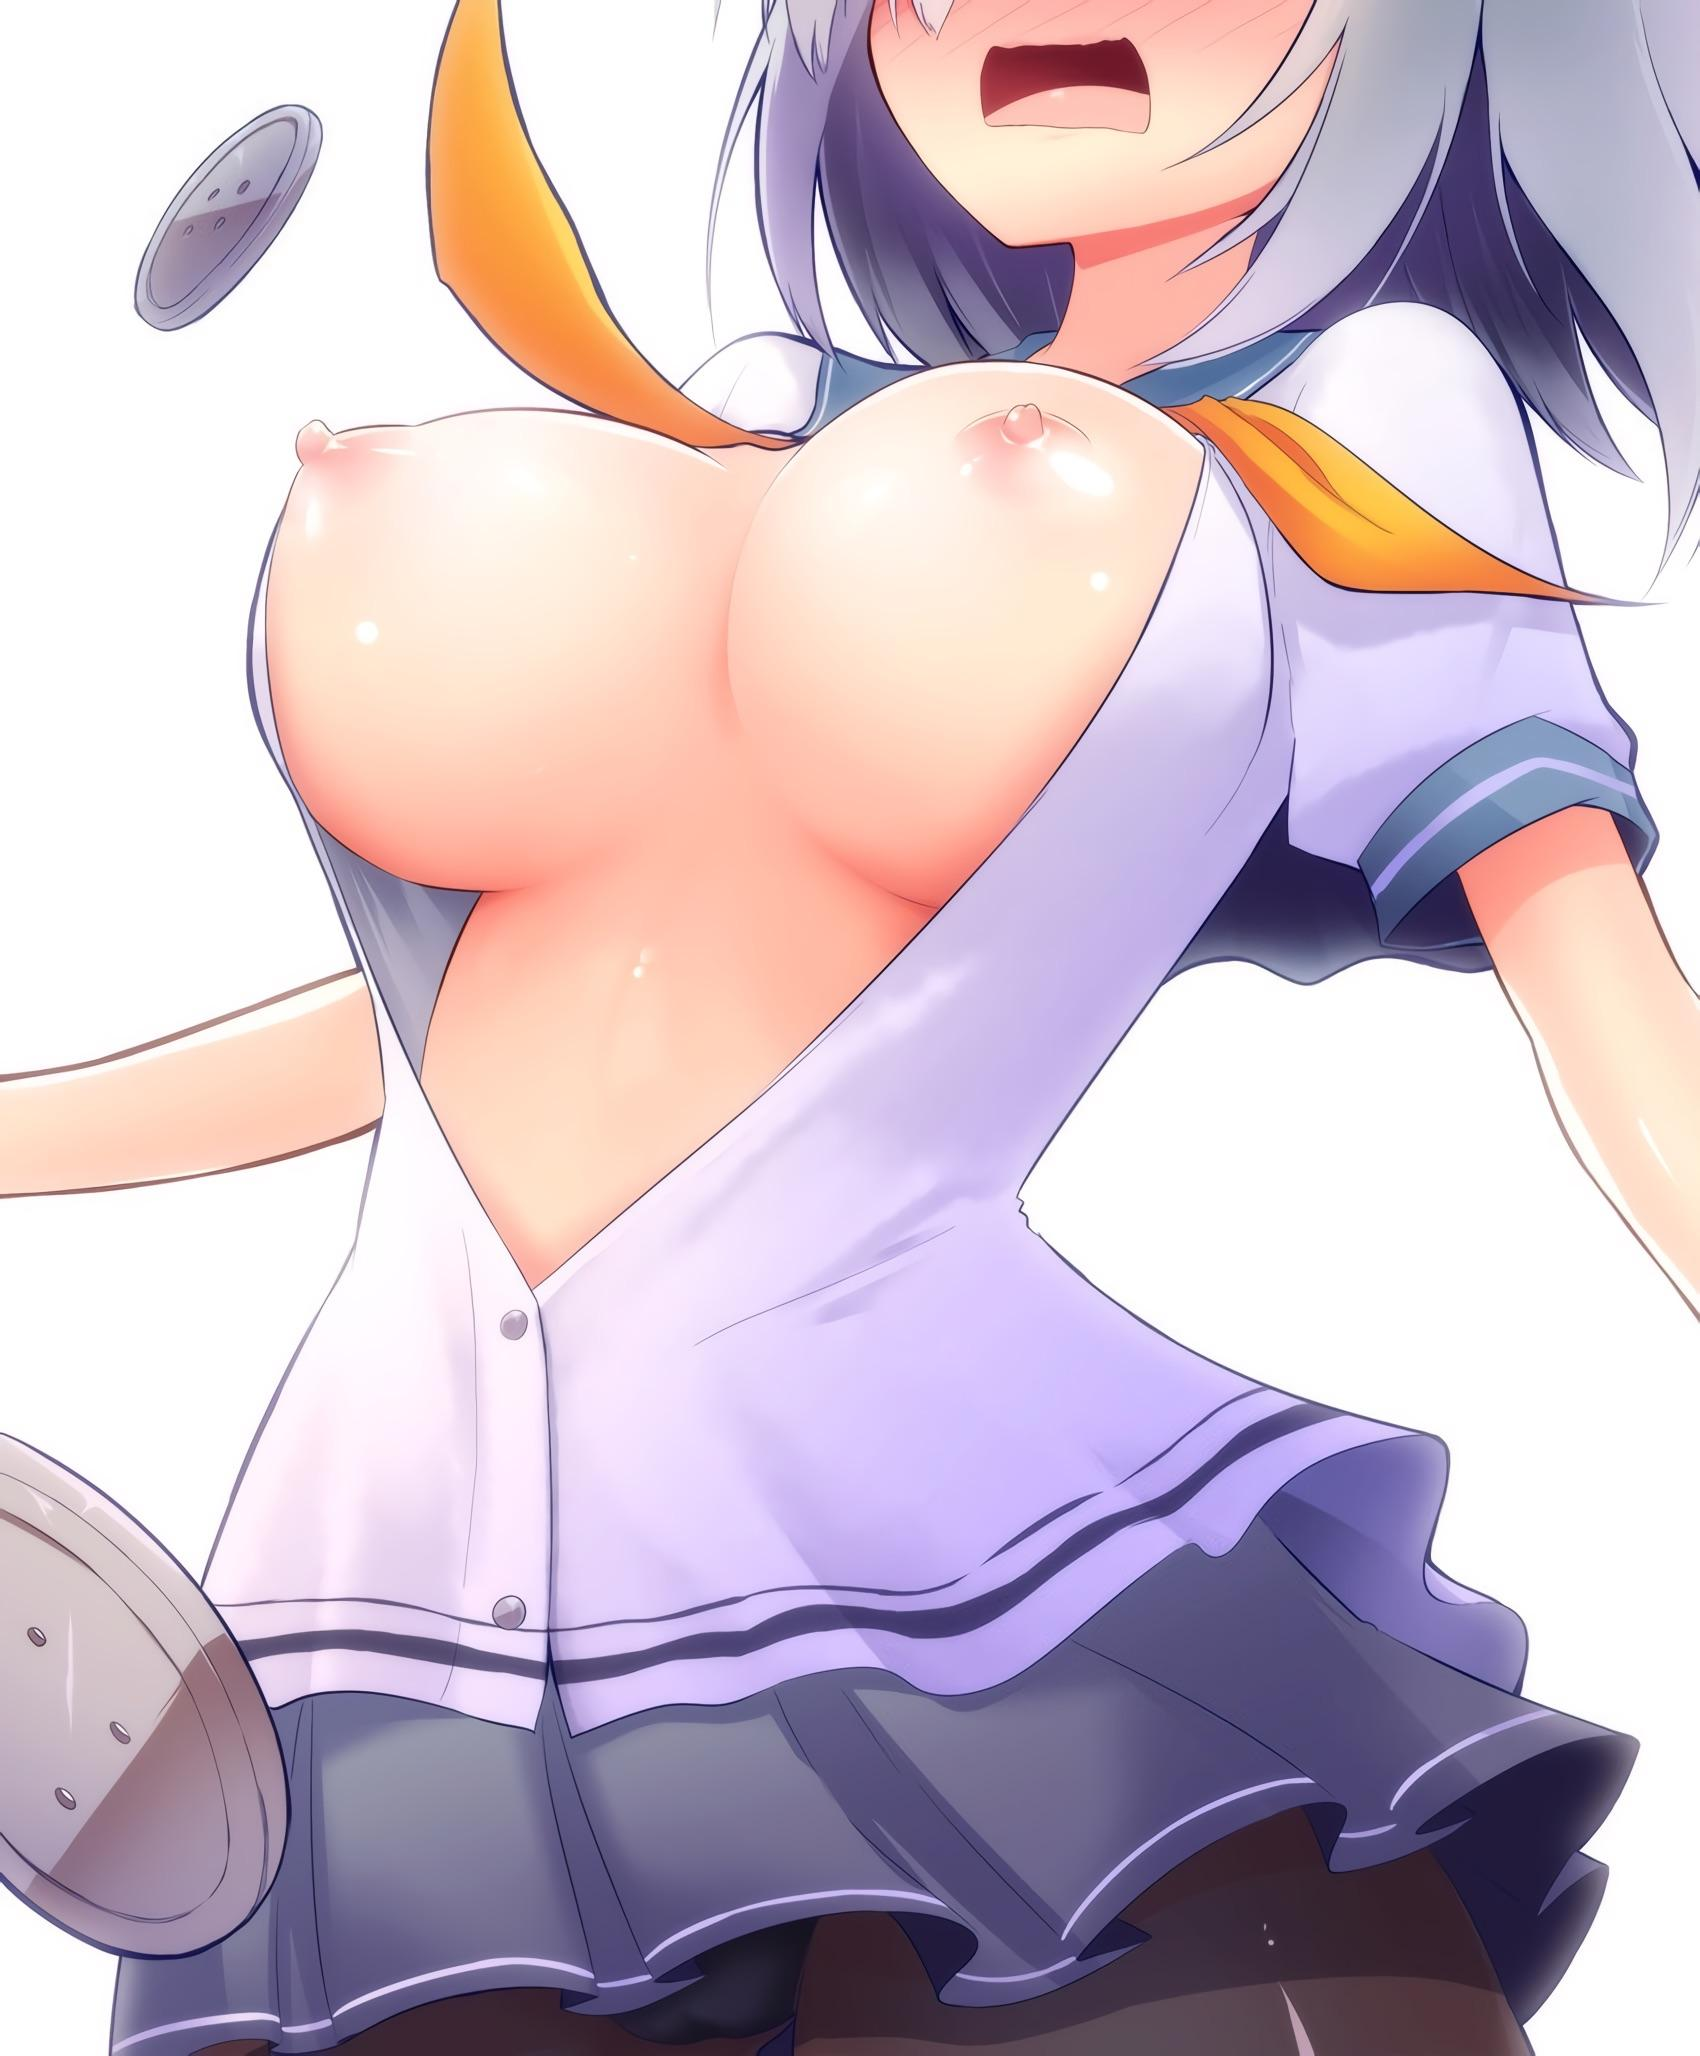

This is an NSFW image


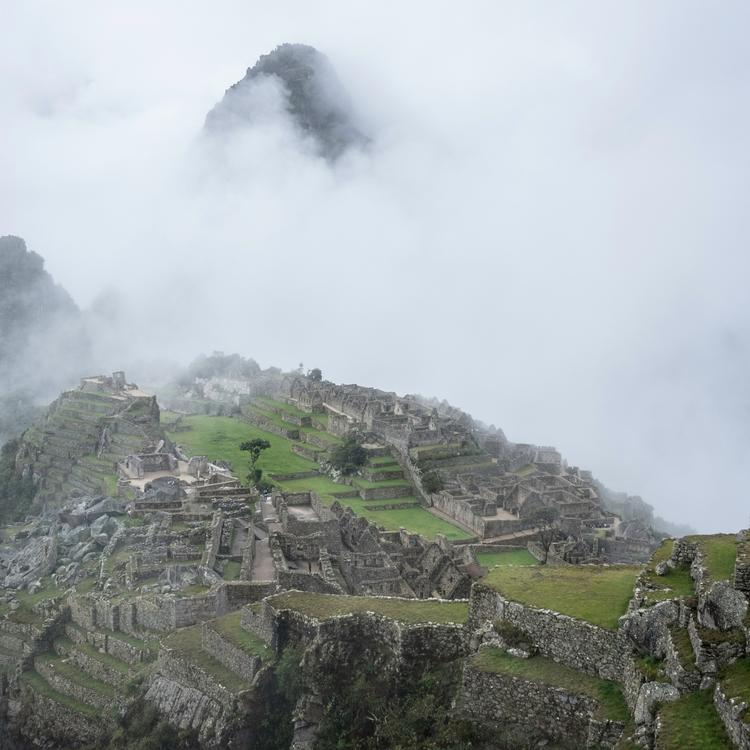

This is a SFW image


In [22]:
os.chdir(r'D:\Data\Test')

number_of_random_images = 0
img_list = []

while (number_of_random_images<5):
    img_list.append(random.choice(os.listdir(os.getcwd())))
    number_of_random_images = number_of_random_images + 1
    
#img_list2 = ['img 70.jpg', 'img 74.jpg', 'img 100.jpg', 'img 105.jpg']

for test_img in img_list:
    #display(Image(filename=test_img, height=100, width=100))
    display(Image(test_img))
    img = image.load_img(test_img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    yhat = model.predict(img)
    if(np.argmax(yhat) == 0):
        print("This is an NSFW image")
    else:
        print("This is a SFW image")   